# Raw audio processing pipeline

In [1]:
import sys
sys.path.append('../')

from hvo_sequence.hvo_seq import HVO_Sequence

import os
import numpy as np
import pickle

## Get one example from dataset: 2 bars, 4-4, 120 bpm

In [2]:
source_path = "../processed_dataset/Processed_On_27_04_2021_at_19_04_hrs"
print(os.path.join(source_path, "GrooveMIDI_processed_train", "hvo_data.obj"))
train_file = open(os.path.join(source_path, "GrooveMIDI_processed_train", "hvo_sequence_data.obj"),'rb')
train_set = pickle.load(train_file)
dataset_size = len(train_set)
# ix =  int(np.random.random_sample()*dataset_size)
example = train_set[52] # 4-4 120 bpm 2 bars
example.to_html_plot(show_figure=True)

../processed_dataset/Processed_On_27_04_2021_at_19_04_hrs/GrooveMIDI_processed_train/hvo_data.obj


Figure(id='1002', ...)

## Multiband onset strength from QC Transform

In [19]:
# https://github.com/mcartwright/dafx2018_adt/blob/master/large_vocab_adt_dafx2018/features.py

import librosa
import scipy.signal
import numpy as np
import resampy
import soundfile as psf

# IN ORDER TO CALC HOP SIZE
FRAME_INTERVAL = 0.01  # s

def read_audio(filepath, sr=None, mono=True, peak_norm=False):
    """
    Read audio
    Parameters
    ----------
    filepath
    sr
    mono
    Returns
    -------
    y, sr
    """
    try:
        y, _sr = psf.read(filepath)
        y = y.T
    except RuntimeError:
        y, _sr = librosa.load(filepath, mono=False, sr=None)

    if sr is not None and sr != _sr:
        y = resampy.resample(y, _sr, sr, filter='kaiser_fast')
    else:
        sr = _sr

    if mono:
        y = librosa.to_mono(y)

    if peak_norm:
        y /= np.max(np.abs(y))

    return y, sr


def cq_matrix(bins_per_octave, num_bins, f_min, fft_len, sr):
    """
    Compute center frequencies of the log-spaced filterbank
    Parameters
    ----------
    bins_per_octave : int
    num_bins : int
    f_min : float
    fft_len : int
    sr : float
    Returns
    -------
    c_mat
    """
    # note range goes from -1 to bpo*num_oct for boundary issues
    f_cq = f_min * 2 ** ((np.arange(-1, num_bins+1)) / bins_per_octave)         # center frequencies
    # centers in bins
    kc = np.round(f_cq * (fft_len / sr)).astype(int)
    c_mat = np.zeros([num_bins, int(np.round(fft_len / 2))])
    for k in range(1, kc.shape[0]-1):
        l1 = kc[k]-kc[k-1]
        w1 = scipy.signal.triang((l1 * 2) + 1)
        l2 = kc[k+1]-kc[k]                             
        w2 = scipy.signal.triang((l2 * 2) + 1)
        wk = np.hstack([w1[0:l1], w2[l2:]])  # concatenate two halves. l1 and l2 are different because of the log-spacing
        c_mat[k-1, kc[k-1]:(kc[k+1]+1)] = wk / np.sum(wk)  # normalized to unit sum;
    return c_mat, f_cq        # matrix with triangular filterbank


def onset_detection_fn(x, f_win_size, f_hop_size, f_bins_per_octave, f_octaves, f_fmin, sr, mean_filter_size):
    """
    Filter bank for onset pattern calculation
    """
    # calculate frequency constant-q transform
    f_win = scipy.signal.hann(f_win_size)
    x_spec = librosa.stft(x,
                          n_fft=f_win_size,
                          hop_length=f_hop_size,
                          win_length=f_win_size,
                          window=f_win)
    x_spec = np.abs(x_spec) / (2 * np.sum(f_win))

    f_cq_mat,f_cq = cq_matrix(f_bins_per_octave, f_octaves * f_bins_per_octave, f_fmin, f_win_size, sr)
    x_cq_spec = np.dot(f_cq_mat, x_spec[:-1, :])

    # subtract moving mean
    b = np.concatenate([[1], np.ones(mean_filter_size, dtype=float) / -mean_filter_size])       # DIFFERENCE BETWEEN THE CURRENT FRAME AND THE MEAN OF THE PREVIOUS mean_filter_size FRAMES 
    od_fun = scipy.signal.lfilter(b, 1, x_cq_spec, axis=1)                                      

    # half-wave rectify
    od_fun = np.maximum(0, od_fun)

    # post-process OPs
    od_fun = np.log10(1 + 1000*od_fun)                  ## log scaling
    return od_fun, x_cq_spec, f_cq


def extract_features(audio_file_path, sr=22050, channel=1):
    x, sr = read_audio(audio_file_path, mono=True, sr=sr)

    f_win_size = 1024
    f_hop_size = int(round(FRAME_INTERVAL * sr))
    f_bins_per_octave =16
    f_octaves = 9
    f_fmin = 40
    mean_filter_size = 22

    # normalize
    x /= np.max(np.abs(x))

    od_fun, x_cq_spec, f_cq = onset_detection_fn(x,
                                           f_win_size,
                                           f_hop_size,
                                           f_bins_per_octave,
                                           f_octaves,
                                           f_fmin,
                                           sr,
                                           mean_filter_size)

    logf_stft = librosa.power_to_db(x_cq_spec).astype('float32')
    od_fun = np.abs(od_fun).astype('float32')

    # reorder axis
    logf_stft= np.moveaxis(logf_stft, 1, 0)
    od_fun = np.moveaxis(od_fun, 1, 0)
    
    # clip od_fun
    od_fun = np.clip(od_fun/2.25, 0, 1)    # 2.25 ?????????

    return logf_stft, od_fun, f_cq

Text(0.5, 1.0, 'Multi-band onset strength')

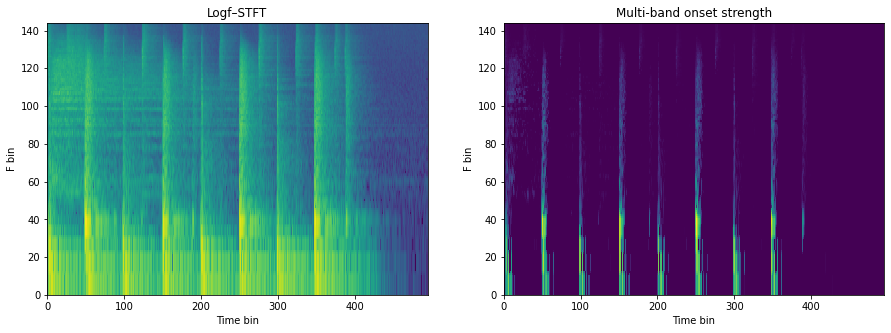

In [20]:
import matplotlib.pyplot as plt
sr=44100
logf_stft, mb_onset_strength, f_cq = extract_features("./misc/temp.wav",sr=sr)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].pcolormesh(logf_stft.T)
ax[0].set_xlabel('Time bin')
ax[0].set_ylabel('F bin')
ax[0].set_title('Logf–STFT')

ax[1].pcolormesh(mb_onset_strength.T)
ax[1].set_xlabel('Time bin')
ax[1].set_ylabel('F bin')
ax[1].set_title('Multi-band onset strength')


## Frequency reduction (pooling) of multi-band onset strength spectrogram

In [21]:
# define center frequencies for the pooled bands
f_c0 = [55, 90, 138, 175, 350, 6000,8500,12500]                      # Perfe center frequencies
f_c0_idx = np.array([],dtype=int)   # empty array to store the indexes

for f in f_c0:
    f_c0_idx = np.append(f_c0_idx, np.abs(f_cq - f).argmin())         # center frequencies indexes

# find band limit indexes
f_band_idx = np.array([0], dtype=int)

for i in range(len(f_c0_idx)-1):
    li = np.ceil((f_c0_idx[i+1] - f_c0_idx[i]) / 2) + f_c0_idx[i]      # find left border of band 
    f_band_idx = np.append(f_band_idx, [li])

f_band_idx = np.append(f_band_idx,len(f_cq))    # add last frequency
f_band_idx = np.array(f_band_idx,dtype=int)     # convert to int
n_bands = len(f_band_idx) - 1

# multi-band onset strength spectrogram frequency pooling
n_timeframes = mb_onset_strength.shape[0]       # calc using stft parameters

# init empty spectrogram
mb_onset_strength_f_red = np.zeros([n_timeframes, n_bands])

for i in range(len(f_band_idx)-1):
    li = f_band_idx[i]+1        # band left index
    if i == 0: li = 0           
    ri = f_band_idx[i+1]        # band right index
    mb_onset_strength_f_red[:, i] = np.max(mb_onset_strength[:,li:ri],axis=1)   # pooling

Text(0.5, 1.0, 'Multi-band onset strength frequency reduced')

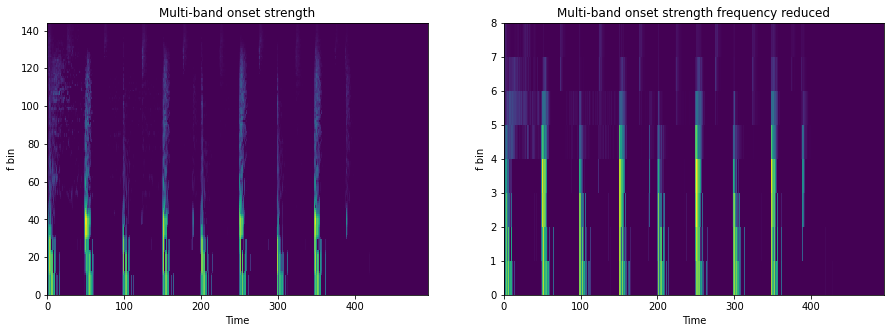

In [22]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].pcolormesh(mb_onset_strength.T)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('f bin')
ax[0].set_title('Multi-band onset strength')

ax[1].pcolormesh(mb_onset_strength_f_red.T)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('f bin')
ax[1].set_title('Multi-band onset strength frequency reduced')



## Onset detection from frequency pooled multi-band spectrogram

Text(0.5, 1.0, 'Multi-band onset detection')

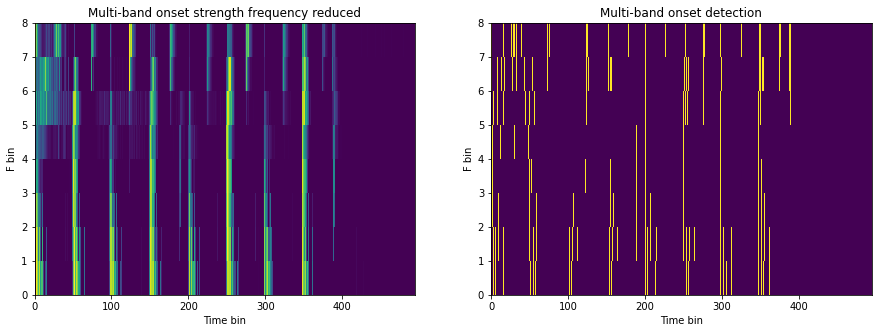

In [23]:
# onset detect por bands 
mb_onset_detect = np.zeros([n_timeframes, n_bands])

for band in range(n_bands):
    time_frame_idx = librosa.onset.onset_detect(onset_envelope=mb_onset_strength_f_red.T[band,:])
    mb_onset_detect[time_frame_idx,band] = 1

# plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].pcolormesh(mb_onset_strength_f_red.T)
ax[0].set_xlabel('Time bin')
ax[0].set_ylabel('F bin')
ax[0].set_title('Multi-band onset strength frequency reduced')

ax[1].pcolormesh(mb_onset_detect.T)
ax[1].set_xlabel('Time bin')
ax[1].set_ylabel('F bin')
ax[1].set_title('Multi-band onset detection')




## Map into grid

In [24]:
# create empty hvo sequence with temporal grid of 4-4 120 with 4 subdivisions to get temporal grid
hvo_seq = HVO_Sequence()
hvo_seq.add_time_signature(time_step=0, numerator=4, denominator=4, beat_division_factors=[4])
hvo_seq.add_tempo(time_step=0, qpm = 120)

#total number of steps is total_number_of_bars*time_signature_numerator*beat_division_factor
n_bars = 2
time_signature_numerator = 4
beat_division_factor = 4
n_timesteps = n_bars*time_signature_numerator*beat_division_factor

# Create a zero hvo
hits = np.zeros([n_timesteps, n_bands])
vels = np.zeros([n_timesteps, n_bands])
offs = np.zeros([n_timesteps, n_bands])

# Add hvo score to hvo_seq instance
hvo_seq.hvo = np.concatenate((hits, vels, offs), axis=1)

# get grid lines
#hvo_seq.grid_lines_with_types
grid = hvo_seq.grid_lines
grid_len = hvo_seq.total_len

../hvo_sequence/hvo_seq.py:92: UserWarning: drum_mapping is not specified
  warnings.warn("drum_mapping is not specified")


In [25]:
from hvo_sequence.io_helpers import get_grid_position_and_utiming_in_hvo

# map intensity and onsets in grid
intensity_grid = np.zeros([n_timesteps + 1,n_bands])
onsets_grid = np.zeros([n_timesteps + 1,n_bands])
time = librosa.frames_to_time(np.arange(n_timeframes), sr=sr, 
                              hop_length=int(round(FRAME_INTERVAL * sr)), n_fft=1024)


for band in range(n_bands):
    for timeframe_idx in range(n_timeframes):       
        if mb_onset_detect[timeframe_idx,band]:         # if there is an onset detected, get grid index and utiming
            grid_idx, utiming = get_grid_position_and_utiming_in_hvo(time[timeframe_idx],grid)
            intensity_grid[grid_idx, band] = mb_onset_strength_f_red[timeframe_idx,band]
            onsets_grid[grid_idx, band] = utiming

In [26]:
print(grid_len,time[-1]) # the grid index has onsets larger than 0.5 

4.0625 4.951609977324263


In [27]:
print(np.round(onsets_grid,2))

[[ 0.33  0.33  0.25  0.25  0.41  0.33  0.17  0.17]
 [ 0.37  0.37 -0.11  0.    0.05  0.37  0.21  0.37]
 [ 0.    0.    0.    0.    0.    0.    0.33  0.41]
 [ 0.    0.    0.    0.   -0.43  0.   -0.27  0.29]
 [ 0.49  0.49  0.09  0.33  0.01  0.25  0.41  0.25]
 [ 0.29  0.29 -0.19  0.    0.   -0.35  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.01  0.17]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.49  0.25  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.05  0.13 -0.35  0.    0.    0.05  0.    0.  ]
 [ 0.    0.    0.   -0.07  0.    0.01  0.25  0.17]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.41  0.41  0.49  0.49  0.17  0.17  0.49  0.33]
 [ 0.21  0.29 -0.19  0.    0.    0.   -0.35 -0.43]
 [ 0.    0.    0.    0.    0.    0.25  0.25  0.41]
 [ 0.    0.21  0.21  0.21  0.21  0.    0.    0.  ]
 [ 0.41  0.41  0.17  0.17  0.17  0.17  0.17  0.17]
 [ 0.21  0.29 -0.27  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.09  0.09  0.25]
 [ 0.    0.    0.    0.    0.  

In [ ]:
print(n)